# Heart Disease Prediction Using Machine Learning

## Introduction

Heart disease is a major health issue worldwide, and it is difficult to discover the disease before symptoms emerge. Our goal of this project is to utilize machine learning techniques and predict whether or not a person has heart disease. This will be done through our dataset, which is derived from the Cleveland Heart Disease Database and consists of 14 important attributes selected from a total of 76. It encompasses a range of variables including physical and psychological details, such as age, sex, cholesterol, etc. It also categorizes individuals based on the absence (value 0) or presence (values 1-4) of heart disease, providing a clear framework for analyzing the predictive power of medical test results. The columns are as follows:

1. **age**: age
2. **sex**: sex (1 = male, 0 = female)
3. **cp**: chest pain type
4. **trestbps**: resting blood pressure in mmHg
5. **chol**: serum cholestoral in mg/dl
6. **fbs**: fasting blood sugar > 120 mg/dl? (1 = True, 0 = False)
7. **restecg**: resting electrocardiographic results
8. **thalach**: maximum heart rate achieved
9. **exang**: whether exercise induced angina (1 = True, 0 = False)
10. **oldpeak**: ST depression induced by exercise, relative to rest
11. **slope**: the slope of the peak exercise ST segment (1 = upslope, 2 = flat, 3 = `b`downslope)
12. **ca**: number of major vessels (0-3) coloured by flourosopy
13. **thal**: (3 = normal, 6 = fixed defect, 7 = reversable defect)
14. **num**: diagnosis of heart disease (1,2,3,4 = presence, 0 = no presence)

### Methods

#### Preprocessing and exploratory data analysis

1) Imported libraries and `processed.cleveland.data` dataset from the internet.

2) Cleaned and tidied data to make it usable, by assigning column types and adding a new column, `diag`.

3) Split the data into training and testing sets, working **only** with the training set until the very end.

4) Summarized the training set to make predictions about how we want our classifier to work.

5) Visualized the relationship between `thalac` and `chol` to get a deeper understanding of how the data is distributed.


#### Finding the best $k$ value

Our goal is to find the best value for the $k$-nearest neighbours, providing the highest accuracy in predictions. In the code below, we create a classifier and perform cross-validation to split the training data, train the model with one set and use the other to evaluate it because we can not use testing data. Our next steps are:

1) Use the `recipe` function to center and scale the data.

2) Perform cross-validation with ten folds, using `vfold_cv`, on the training data. We use ten folds because if we only split the data once, the results strongly depend on the observations that end up being in the validation set, so using more folds increases the accuracy.

3) Create a $k$-nearest model with `neighbours = tune()` instead of a value to find the best value of $k$ for $k$-nearest neighbours.

4) Add the recipe and model to a workflow, using `tune_grid` to fit. This worfklow runs cross validation on a range of $k$-nearest neighbours values that is specified in `gridvals`.

5) Find the best $k$ value by filtering for accuracy and plotting a line plot with the accuracy estimate on the y-axis and $k$ (neighbours) on the x-axis.

6) Ensure that the model does not underfit or overfit, and is more accurate than a majority classifier, using our new $k$.

#### Visualizing our results

1) To visualize our results, we plotted max heart rate on the x-axis and cholesterol levels on the y-axis, using diagnosis to colour the points.

2) To check for over/underfitting, we coloured the background of the graph based on what prediction would be made at every possible point. This also allowed us to quickly identify how the model classified patients, and where the boundaries were.

#### Testing our classifier

1) Made a new model specification for the best $k$ value chosen, combined with the recipe made earlier in a workflow, and fit the classifier to our training set.

2) Used `predict` on the testing set to evaluate the classifier's predicition accuracy on data it hadn't seen before.

3) Produced a confusion matrix to get a sense of which diagnoses the classifier was more accurate at giving, and what effects that has on real world application.

4) Tested the accuracy of our classifier when given data from Hungary.

In [1]:
# importing libraries
library(tidyverse)
library(tidymodels)
library(repr)
library(RColorBrewer)
library(cowplot)
set.seed(0)
# formatting graphs
options(repr.plot.width = 12, repr.plot.height = 6)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

## Importing the dataset 


We use the  `read_csv` to import the processed.cleveland.data dataset from the online directory.

In [2]:
cleveland<- read_csv("data/processed_cleveland.csv")

head(cleveland)

nrow(cleveland)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


[1] 303

## Cleaning and Tidying the Data 

In [3]:
cleveland_data <- cleveland |>
                    mutate(sex = as_factor(sex),
                       cp = as_factor(cp),
                       fbs = as_factor(fbs),
                       restecg = as_factor(restecg),
                       exang = as_factor(exang),
                       slope = as_factor(slope),
                       thal = as_factor(thal),
                       num = as_factor(ifelse(is.na(num), NA, (num > 0))),
                       ca = as.integer(ca))|>
                rename(chest_pain = cp,
                       blood_pressure = trestbps,
                       cholesterol = chol,
                       blood_sugar = fbs,
                       rest_ecg = restecg,
                       heart_rate = thalach,
                       angina = exang,
                       st_depression = oldpeak,
                       num_vessels = ca,
                       diagnosis = num)


head(cleveland_data)

nrow(cleveland_data)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `ca = as.integer(ca)`.
Caused by warning:
! NAs introduced by coercion”


age,sex,chest_pain,blood_pressure,cholesterol,blood_sugar,rest_ecg,heart_rate,angina,st_depression,slope,num_vessels,thal,diagnosis
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<int>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6.0,FALSE
67,1,4,160,286,0,2,108,1,1.5,2,3,3.0,TRUE
67,1,4,120,229,0,2,129,1,2.6,2,2,7.0,TRUE
37,1,3,130,250,0,0,187,0,3.5,3,0,3.0,FALSE
41,0,2,130,204,0,2,172,0,1.4,1,0,3.0,FALSE
56,1,2,120,236,0,0,178,0,0.8,1,0,3.0,FALSE


[1] 303

In [4]:
set.seed(0)
cleveland_split <- initial_split(cleveland_data, prop = 0.75, strata = diagnosis)
cleveland_train <- training(cleveland_split)
cleveland_test <- testing(cleveland_split)

head(cleveland_train)

nrow(cleveland_train)
nrow(cleveland_test)

age,sex,chest_pain,blood_pressure,cholesterol,blood_sugar,rest_ecg,heart_rate,angina,st_depression,slope,num_vessels,thal,diagnosis
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<int>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6.0,FALSE
37,1,3,130,250,0,0,187,0,3.5,3,0,3.0,FALSE
41,0,2,130,204,0,2,172,0,1.4,1,0,3.0,FALSE
57,1,4,140,192,0,0,148,0,0.4,2,0,6.0,FALSE
56,0,2,140,294,0,2,153,0,1.3,2,0,3.0,FALSE
57,1,3,150,168,0,0,174,0,1.6,1,0,3.0,FALSE


[1] 227

[1] 76

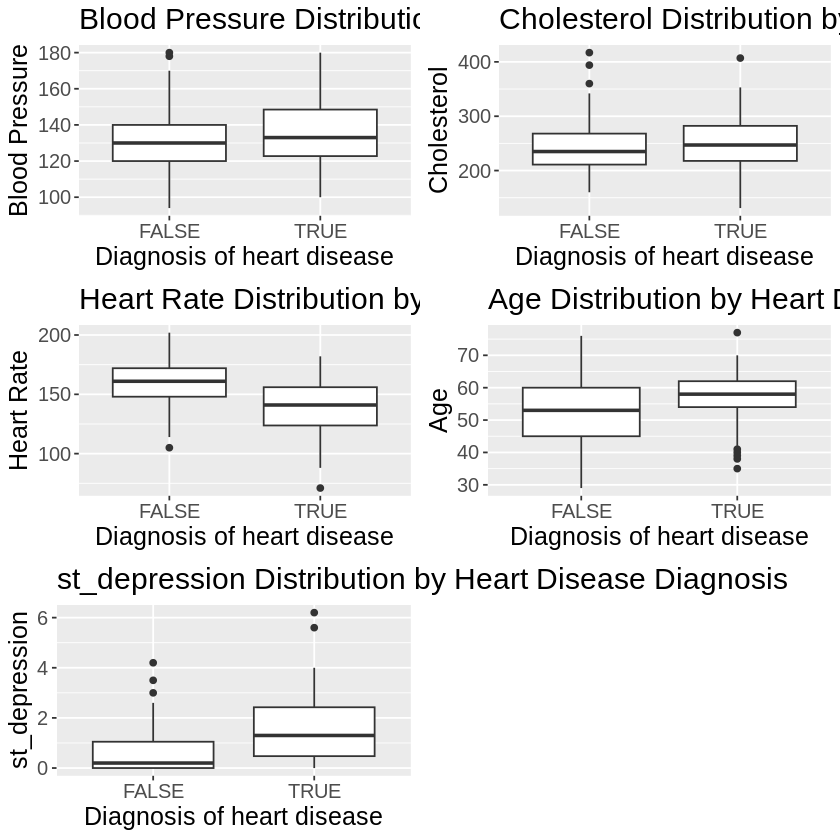

In [5]:
options(repr.plot.height = 7, repr.plot.width = 7)
bp_box_plot <- cleveland_train |> ggplot(aes(x = diagnosis, y = blood_pressure)) + geom_boxplot() +
            labs(x = "Diagnosis of heart disease", y = "Blood Pressure", title = "Blood Pressure Distribution by Heart Disease Diagnosis") + 
            theme(text = element_text(size = 15))

chol_box_plot <- cleveland_train |> ggplot(aes(x = diagnosis, y = cholesterol)) + geom_boxplot() +
            labs(x = "Diagnosis of heart disease", y = "Cholesterol", title = "Cholesterol Distribution by Heart Disease Diagnosis") + 
            theme(text = element_text(size = 15))

hr_box_plot <- cleveland_train |> ggplot(aes(x = diagnosis, y = heart_rate)) + geom_boxplot() +
            labs(x = "Diagnosis of heart disease", y = "Heart Rate", title = "Heart Rate Distribution by Heart Disease Diagnosis") + 
            theme(text = element_text(size = 15))
age_box_plot <- cleveland_train |> ggplot(aes(x = diagnosis, y = age)) + geom_boxplot() +
            labs(x = "Diagnosis of heart disease", y = "Age", title = "Age Distribution by Heart Disease Diagnosis") + 
            theme(text = element_text(size = 15))
dep_box_plot <- cleveland_train |> ggplot(aes(x = diagnosis, y = st_depression)) + geom_boxplot() +
            labs(x = "Diagnosis of heart disease", y = "st_depression", title = "st_depression Distribution by Heart Disease Diagnosis") + 
            theme(text = element_text(size = 15))
plot_grid(bp_box_plot, chol_box_plot, hr_box_plot,age_box_plot, dep_box_plot, ncol = 2)


In [6]:
## Forward Selection???
cleveland_subset <- cleveland_train |> select(diagnosis, cholesterol, heart_rate, age, st_depression, blood_pressure)
names <- cleveland_subset |> select(-diagnosis) |> colnames()

In [7]:
example_formula <- paste("diagnosis", "~", paste(names, collapse="+"))
example_formula

[1] "diagnosis ~ cholesterol+heart_rate+age+st_depression+blood_pressure"

In [8]:
set.seed(0)
# create an empty tibble to store the results
accuracies <- tibble(size = integer(),
                     model_string = character(),
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5-fold cross-validation object
hd_vfold <- vfold_cv(cleveland_subset, v = 5, strata = diagnosis)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("diagnosis", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        hd_fs_recipe <- recipe(as.formula(model_string),
                                data = cleveland_subset) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the K-NN classifier with these predictors,
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(hd_fs_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = hd_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |>
      add_row(size = i,
              model_string = models[[jstar]],
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies_arranged <- accuracies |> arrange(desc(accuracy))

In [9]:
accuracies_arranged

size,model_string,accuracy
<int>,<chr>,<dbl>
3,diagnosis ~ st_depression+heart_rate+blood_pressure,0.7268072
4,diagnosis ~ st_depression+heart_rate+blood_pressure+age,0.7261221
5,diagnosis ~ st_depression+heart_rate+blood_pressure+age+cholesterol,0.7048704
2,diagnosis ~ st_depression+heart_rate,0.7003206
1,diagnosis ~ st_depression,0.6917347


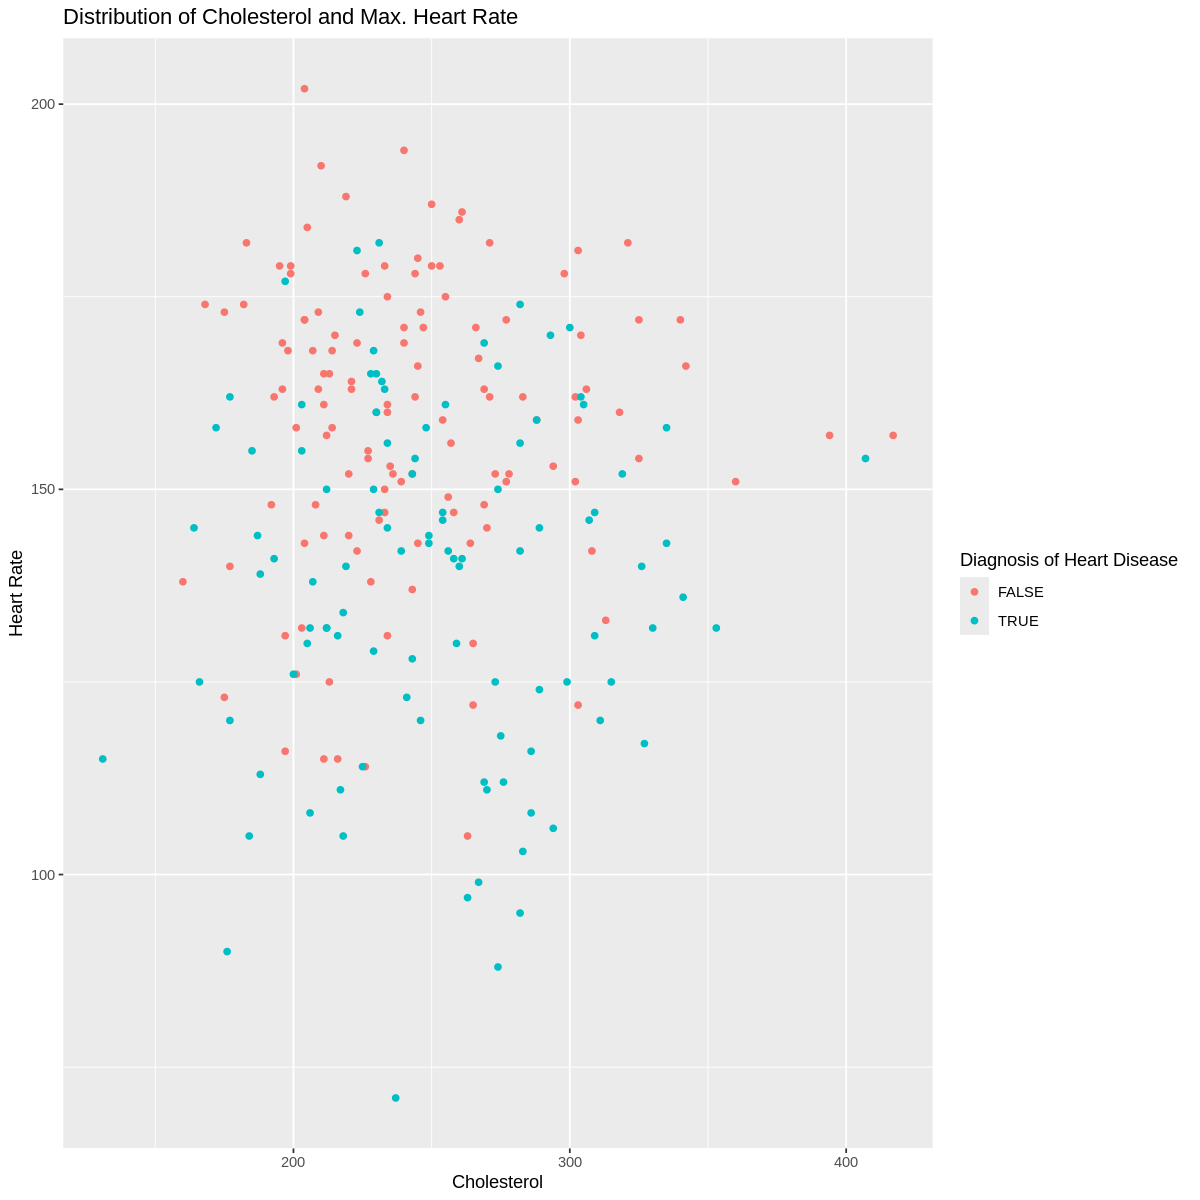

In [10]:
options(repr.plot.height = 10, repr.plot.width = 10)
chol_hr_plot <- cleveland_train |> ggplot(aes(x = cholesterol, y = heart_rate, color = diagnosis)) + geom_point() +
labs(x = "Cholesterol", y = "Heart Rate", color = "Diagnosis of Heart Disease") + 
ggtitle("Distribution of Cholesterol and Max. Heart Rate")
chol_hr_plot

neighbors,mean
<int>,<dbl>
75,0.6996871
76,0.6996871
73,0.6905962
74,0.6905962
87,0.6873847
88,0.6873847


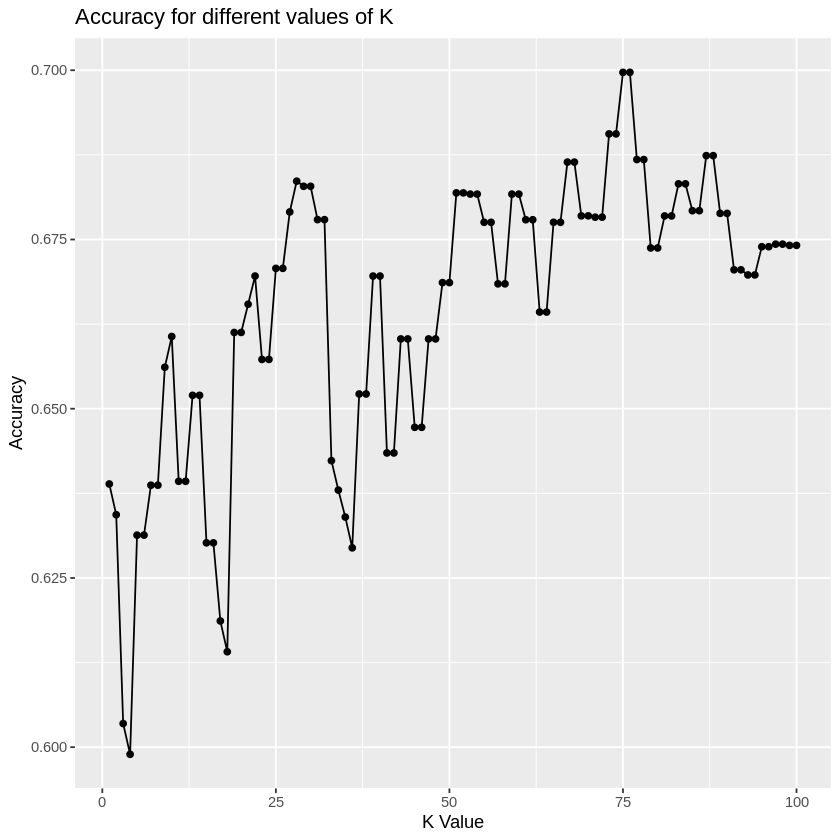

In [11]:
set.seed(0)
options(repr.plot.height = 7, repr.plot.width = 7)
hd_recipe <- recipe(diagnosis ~ cholesterol + heart_rate, data = cleveland_train) |> step_scale(all_predictors()) |> step_center(all_predictors())
hd_tune_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

hd_vfold <- vfold_cv(cleveland_train, v = 10, strata = diagnosis)
gridvals <- tibble(neighbors = c(1:100))

hd_wkflw <- workflow() |>
      add_recipe(hd_recipe) |>
      add_model(hd_tune_spec) |>
      tune_grid(resamples = hd_vfold, grid = gridvals) |>
      collect_metrics() |>
      filter(.metric == "accuracy") |>
      select(neighbors, mean) |>
      arrange(desc(mean))
head(hd_wkflw)



hd_result_plot <- hd_wkflw |> ggplot(aes(x = neighbors, y = mean)) + geom_point() + geom_line() + 
labs(x = "K Value", y = "Accuracy") + ggtitle("Accuracy for different values of K")
hd_result_plot


In [12]:
kmin <- hd_wkflw |> slice(1) |> pull(neighbors)

hd_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) |>
  set_engine("kknn") |>
  set_mode("classification")

hd_fit <- workflow() |>
  add_recipe(hd_recipe) |>
  add_model(hd_spec) |>
  fit(data = cleveland_train)

hd_summary <- hd_fit |>
  predict(cleveland_test) |>
  bind_cols(cleveland_test) 

hd_accuracy <- hd_summary |>
  metrics(truth = diagnosis, estimate = .pred_class) |>
  filter(.metric == 'accuracy')
hd_accuracy
hd_conf_mat<- hd_summary |>
    conf_mat(truth = diagnosis, estimate = .pred_class)
hd_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6578947


          Truth
Prediction FALSE TRUE
     FALSE    35   20
     TRUE      6   15

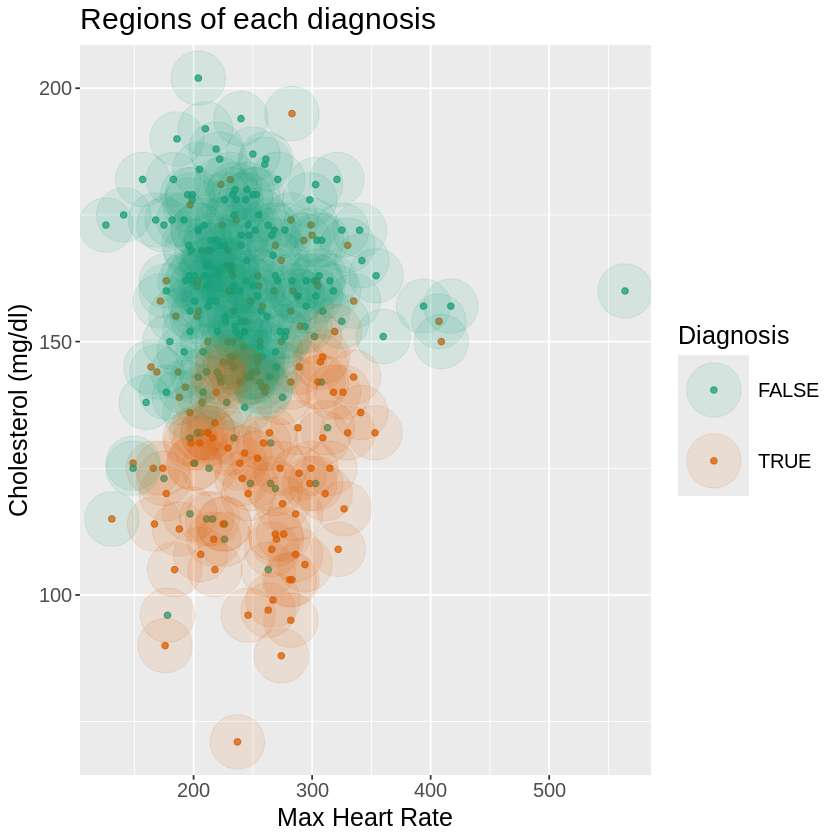

In [13]:
hd_fit_summary <- hd_fit |>
  predict(cleveland_data) |>
  bind_cols(cleveland_data)
hd_fit_plot <- ggplot() + geom_point(data = cleveland_test, mapping = aes(x = cholesterol, y = heart_rate, color = diagnosis)) +
geom_point(data = hd_summary, mapping = aes(x = cholesterol, y = heart_rate, color = .pred_class), alpha = 0.02, size = 5) +
labs(x = "Cholesterol", y = "Max. Heart Rate", color = "Diagnosis") + theme(text = element_text(size = 12))
plot_results <- ggplot() + 
                geom_point(data = cleveland_data, 
                mapping = aes(x = cholesterol, y = heart_rate, color = diagnosis), 
                alpha = 0.75) +
                geom_point(data = hd_fit_summary, 
                           mapping = aes(x = cholesterol, 
                           y = heart_rate, 
                           color = .pred_class), 
                           alpha = 0.1, 
                           size = 15) +
                labs(x = "Max Heart Rate", y = "Cholesterol (mg/dl)", 
                     color = "Diagnosis", 
                     title = "Regions of each diagnosis") +
                scale_color_brewer(palette = "Dark2") +
                theme(text = element_text(size = 15))
plot_results

neighbors,mean
<int>,<dbl>
33,0.7356555
34,0.7356555
35,0.7356555
36,0.7356555
51,0.7356555
52,0.7356555


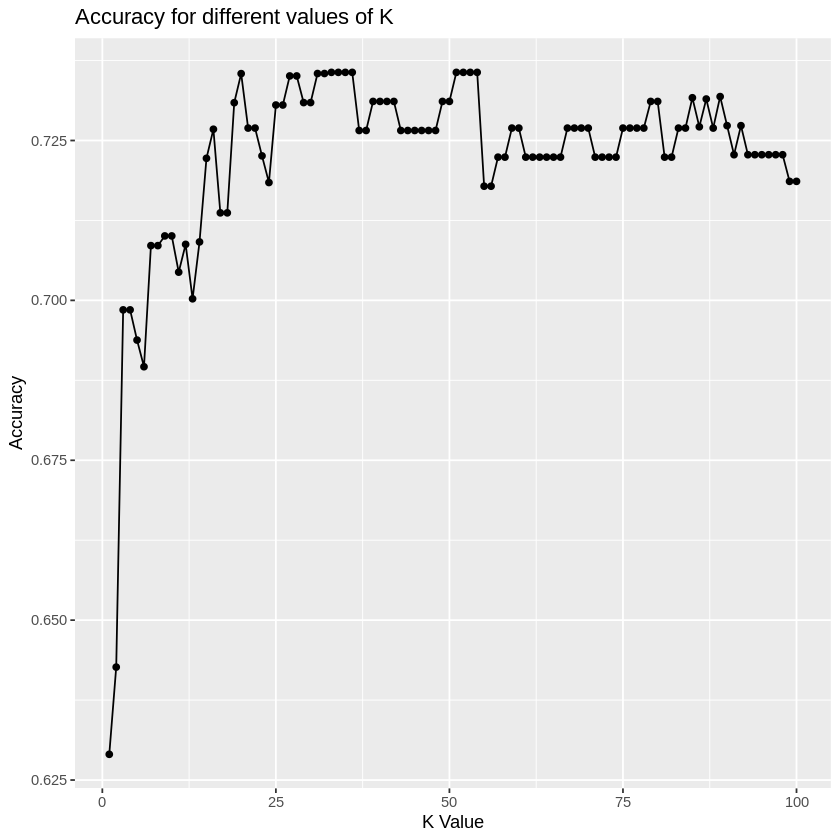

In [14]:
set.seed(0)
dep_recipe <- recipe(diagnosis ~ st_depression + heart_rate, data = cleveland_train) |> step_scale(all_predictors()) |> step_center(all_predictors())
dep_tune_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

dep_vfold <- vfold_cv(cleveland_train, v = 10, strata = diagnosis)
gridvals <- tibble(neighbors = c(1:100))

dep_wkflw <- workflow() |>
      add_recipe(dep_recipe) |>
      add_model(dep_tune_spec) |>
      tune_grid(resamples = hd_vfold, grid = gridvals) |>
      collect_metrics() |>
      filter(.metric == "accuracy") |>
      select(neighbors, mean) |>
      arrange(desc(mean))
head(dep_wkflw)


options(repr.plot.height = 7, repr.plot.width = 7)
dep_result_plot <- dep_wkflw |> ggplot(aes(x = neighbors, y = mean)) + geom_point() + geom_line() + 
labs(x = "K Value", y = "Accuracy") + ggtitle("Accuracy for different values of K")
dep_result_plot

In [15]:
kmin_dep <- dep_wkflw |> slice(1) |> pull(neighbors)

dep_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin_dep) |>
  set_engine("kknn") |>
  set_mode("classification")

dep_fit <- workflow() |>
  add_recipe(dep_recipe) |>
  add_model(dep_spec) |>
  fit(data = cleveland_train)

dep_summary <- dep_fit |>
  predict(cleveland_test) |>
  bind_cols(cleveland_test) 

dep_accuracy <- dep_summary |>
  metrics(truth = diagnosis, estimate = .pred_class) |>
  filter(.metric == 'accuracy')
dep_accuracy
dep_conf_mat<- dep_summary |> conf_mat(truth = diagnosis, estimate = .pred_class)
dep_conf_mat


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.75


          Truth
Prediction FALSE TRUE
     FALSE    37   15
     TRUE      4   20